In [1]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams; rcParams['font.family'] = ['DejaVu Sans']
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

In [3]:
data = spark.read.csv('/user/mvshevc5/data.csv', inferSchema=True, header=True)
df = pandify2(data).toPandas().drop(['_c0'], axis=1)
train = df

test = spark.read.csv('/user/mvshevc5/test.csv', inferSchema=True, header=True)
test = pandify2(test).toPandas().drop(['_c0'], axis=1)

spark.stop()

/opt/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mvshevc5/.local/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


# Grouped bar chart: treatment groups

In [4]:
df.groupby(['group'])['response_att'].count().to_dict()

{'control': 171137, 'test': 515892}

# Bar chart: response rates by treatment

In [5]:
0.11012576275654594 - 0.1025786358297738

0.0075471269267721325

In [6]:
(df.groupby(['group'])['response_att'].sum() / df.groupby(['group'])['response_att'].count()).to_dict()

{'control': 0.1025786358297738, 'test': 0.11012576275654594}

# Конверсия среди мужчин

In [7]:
female = df[df['gender']=='М'].groupby('group')['response_att'].sum() /\
            df[df['gender']=='М'].groupby('group')['response_att'].count()
uplift_female = female['test'] - female['control']
print(f'{uplift_female * 100:.3f}')

0.815


In [8]:
male = df[df['gender']=='Ж'].groupby('group')['response_att'].sum() /\
            df[df['gender']=='Ж'].groupby('group')['response_att'].count()
uplift_male = male['test'] - male['control']
print(f'{uplift_male * 100:.3f}')


0.739


In [9]:
from tqdm.auto import tqdm

def bootstrap_mean_diff_ci(data_fst, data_snd, alpha=0.05, iters=1000, return_distribution=False):
    dist = []
    for _ in tqdm(range(iters)):
        
        first_sample = data_fst.sample(len(data_fst), replace=True)
        first = first_sample.groupby('group')['response_att'].sum() /\
            first_sample.groupby('group')['response_att'].count()
        first_uplift = first['test'] - first['control']
        
        second_sample = data_snd.sample(len(data_fst), replace=True)
        second = second_sample.groupby('group')['response_att'].sum() /\
            second_sample.groupby('group')['response_att'].count()
        second_uplift = second['test'] - second['control']
        
        dist.append(first_uplift - second_uplift)
        
    if return_distribution:
        return dist
    return np.percentile(dist, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

In [10]:
def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1-x) * 2
    return pvalue

In [11]:
dist = bootstrap_mean_diff_ci(
    df[df['gender']=='М'], df[df['gender']=='Ж'], alpha=0.05, iters=1000, return_distribution=True
)

/home/mvshevc5/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


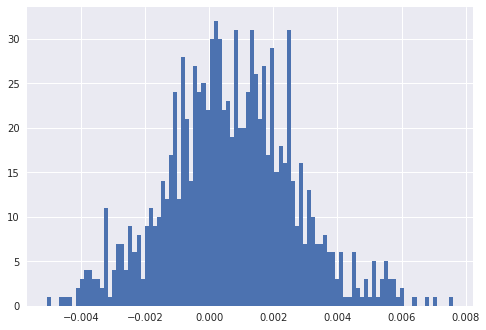

In [12]:
pd.Series(dist).hist(bins=100)

In [13]:
get_p_value(dist)

0.722

# Распределение uplift@k в зависимости от признака

In [14]:
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score
from sklearn.model_selection import train_test_split

def get_feat_uplift(
    feat,
    n_iter=100
):
    uplift_feat = []
    for iter_ in tqdm(range(1, (n_iter+1))):

        _, df_val = train_test_split(
            df, 
            test_size=0.3,
            random_state=42+iter_
        )
        
        df_val.loc[:, 'group'] = df_val['group'].map({
            'test': 1,
            'control': 0
        })

        score_val = uplift_at_k(
            y_true=df_val['response_att'], 
            uplift=df_val[feat], 
            treatment=df_val['group'], 
            strategy='overall', 
            k=0.25
        )

        uplift_feat.append(score_val)
    uplift_feat_res = np.array(uplift_feat)
    return uplift_feat_res

cheque_count_distr = get_feat_uplift('cheque_count_12m_g48', 100)

/home/mvshevc5/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
cheque_count_mean = np.mean(cheque_count_distr)
cheque_count_std = np.std(cheque_count_distr)
random = 0.0075471269267721325

In [46]:
1.13 - 0.33

0.7999999999999998

In [45]:
print(f'Uplift@25% random: {0.0075471269267721325 * 100:.4f}')
print(f'Uplift@25% mean: {cheque_count_mean * 100:.4f}')
print(f'Uplift@25% std: {cheque_count_std * 100:.4f}')

Uplift@25% random: 0.7547
Uplift@25% mean: 1.1317
Uplift@25% std: 0.3339


/home/mvshevc5/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


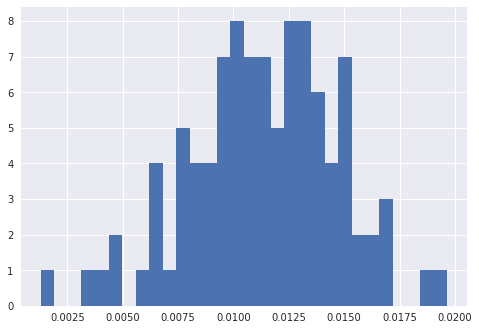

In [16]:
pd.Series(cheque_count_distr).hist(bins=30)

# Adversarial validation: treatment groups

In [17]:
from sklearn.model_selection import train_test_split


Xy_tr, Xy_val = train_test_split(df.drop(['response_att'], axis=1), test_size=0.3, stratify=df['group'])
Xy_tr.loc[:, 'group'] = Xy_tr['group'].map({'test': 1, 'control': 0})
Xy_tr.loc[:, 'gender'] = Xy_tr['gender'].fillna('NAN_cat')

Xy_val.loc[:, 'group'] = Xy_val['group'].map({'test': 1, 'control': 0})
Xy_val.loc[:, 'gender'] = Xy_val['gender'].fillna('NAN_cat')

In [18]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve

model = CatBoostClassifier(task_type='GPU', devices='0')

model.fit(Xy_tr.drop('group', axis=1), Xy_tr['group'].values, cat_features=['gender'], verbose=100)
preds = model.predict_proba(Xy_val.drop('group', axis=1))[:, 1]

score = roc_auc_score(Xy_val['group'].values, preds)

print(score)

Learning rate set to 0.024003
0:	learn: 0.6865859	total: 20.2ms	remaining: 20.2s
100:	learn: 0.5536413	total: 1.84s	remaining: 16.4s
200:	learn: 0.5471125	total: 4.1s	remaining: 16.3s
300:	learn: 0.5463712	total: 6.42s	remaining: 14.9s
400:	learn: 0.5459676	total: 8.68s	remaining: 13s
500:	learn: 0.5457759	total: 10.9s	remaining: 10.9s
600:	learn: 0.5456277	total: 13.1s	remaining: 8.71s
700:	learn: 0.5455185	total: 15.3s	remaining: 6.54s
800:	learn: 0.5453996	total: 17.6s	remaining: 4.37s
900:	learn: 0.5453139	total: 19.9s	remaining: 2.18s
999:	learn: 0.5451959	total: 22.1s	remaining: 0us
0.5551308255098013


In [19]:
preds_smaple = model.predict_proba(Xy_val.drop('group', axis=1).sample(1000, random_state=42))[:, 1]


fpr, tpr, _ = roc_curve(
    Xy_val['group'].sample(1000, random_state=42).values, 
    preds_smaple
)
adv_validation_roc = {
    'roc_auc_score': score,
    'x_model': fpr.tolist(),
    'y_model': tpr.tolist(),
    'x_random': [0, 1],
    'y_random': [0, 1]
}

adv_validation_fi = {
    'features': model.get_feature_importance(prettified=True).head(14)['Feature Id'].values.tolist(),
    'importances': model.get_feature_importance(prettified=True).head(14)['Importances'].values.tolist(),
}

In [20]:
model.get_feature_importance(prettified=True).head(10)

,Feature Id,Importances
0,response_sms,24.445618
1,response_viber,19.575376
2,gender,13.633982
3,sale_count_12m_g49,4.315264
4,k_var_sku_price_6m_g49,3.142772
5,cheque_count_12m_g48,2.495197
6,k_var_disc_share_6m_g49,2.365497
7,promo_share_15d,1.886817
8,food_share_15d,1.824252
9,sale_sum_12m_g27,1.820984


# Adversarial validation: train vs test

In [22]:
from sklearn.model_selection import train_test_split

full = pd.concat([train , test], sort=False).reset_index(drop=True)
full.loc[:, 'adv_target'] = (pd.isna(full['response_att'])).astype(int).values

Xy_tr, Xy_val = train_test_split(
    full.drop(['response_att', 'group'], axis=1), test_size=0.3, 
    stratify=full['adv_target']
)
Xy_tr.loc[:, 'gender'] = Xy_tr['gender'].fillna('NAN_cat')
Xy_val.loc[:, 'gender'] = Xy_val['gender'].fillna('NAN_cat')

In [23]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve

model = CatBoostClassifier(task_type='GPU', devices='0')

model.fit(Xy_tr.drop('adv_target', axis=1), Xy_tr['adv_target'].values, cat_features=['gender'], verbose=100)
preds = model.predict_proba(Xy_val.drop('adv_target', axis=1))[:, 1]

score = roc_auc_score(Xy_val['adv_target'].values, preds)

print(score)

Learning rate set to 0.023532
0:	learn: 0.6892966	total: 21.4ms	remaining: 21.4s
100:	learn: 0.6101373	total: 1.98s	remaining: 17.6s
200:	learn: 0.6084744	total: 4.26s	remaining: 16.9s
300:	learn: 0.6083338	total: 7.18s	remaining: 16.7s
400:	learn: 0.6082361	total: 9.93s	remaining: 14.8s
500:	learn: 0.6081432	total: 12.8s	remaining: 12.7s
600:	learn: 0.6080647	total: 15.6s	remaining: 10.4s
700:	learn: 0.6080045	total: 18.7s	remaining: 7.96s
800:	learn: 0.6079389	total: 21.7s	remaining: 5.38s
900:	learn: 0.6078764	total: 24.7s	remaining: 2.71s
999:	learn: 0.6078205	total: 27.7s	remaining: 0us
0.5063854390831818


In [24]:
preds_smaple = model.predict_proba(Xy_val.drop('adv_target', axis=1).sample(1000, random_state=42))[:, 1]


fpr_trvste, tpr_trvste, _ = roc_curve(
    Xy_val['adv_target'].sample(1000, random_state=42).values, 
    preds_smaple
)
adv_validation_roc_trvste = {
    'roc_auc_score': score,
    'x_model': fpr_trvste.tolist(),
    'y_model': tpr_trvste.tolist(),
    'x_random': [0, 1],
    'y_random': [0, 1]
}

adv_validation_fi_trvste = {
    'features': model.get_feature_importance(prettified=True).head(14)['Feature Id'].values.tolist(),
    'importances': model.get_feature_importance(prettified=True).head(14)['Importances'].values.tolist(),
}

# Формируем json

In [38]:
insights = {
    'Grouped bar chart': df.groupby(['group'])['response_att'].count().to_dict(),
    'Bar chart': (df.groupby(['group'])['response_att'].sum() / df.groupby(['group'])['response_att'].count()).to_dict(),
    'check_count_uplift': {
        'distr': cheque_count_distr.tolist(),
        'cheque_count_mean': cheque_count_mean,
        'cheque_count_std': cheque_count_std,
        'random': random,
    },
    'sex_uplift': {
        'distr': dist,
        'mean': np.mean(dist),
        'std': np.std(dist)
    },
    'adv_treatment': {
        'adv_validation_roc': adv_validation_roc,
        'adv_validation_fi': adv_validation_fi,

    },
    'adv_test': {
        'adv_validation_roc': adv_validation_roc_trvste,
        'adv_validation_fi': adv_validation_fi_trvste,
    }
}

In [39]:
import json

with open("insights.json", "w") as fp:
    json.dump(insights , fp) 